In [1]:
#database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas

import rasterio as rio
import rioxarray as rxa
import os
from os.path import join, expanduser, exists
from glob import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
from datetime import date, datetime, timedelta
from ulmo_extract import get_snotel_within_image
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import contextily as ctx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Import the connection function from the snowexsql library
from snowexsql.db import get_db

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@db.snowexdata.org/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

In [3]:
from snowexsql.data import LayerData, PointData, ImageData, SiteData
# import necessary libraries
from snowexsql.data import SiteData, ImageData
from snowexsql.conversions import raster_to_rasterio, query_to_geopandas
from geoalchemy2.types import Raster
import geoalchemy2.functions as gfunc
from geoalchemy2.shape import from_shape,to_shape
from rasterio.plot import show
from sqlalchemy.sql import func
from rio_geom import rio_to_exterior

In [35]:
image_fp['flight1'].date().year

2020

In [44]:
with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

res = pd.DataFrame()
for i, image_fp in enumerate(image_fps):
    if i == i:
        dic = {}
        loc = image_fp['location']
        dic['loc'] = loc
        dic['t1'] = image_fp['flight1']
        dic['t2'] = image_fp['flight2']
        if image_fp['flight1'].date().year == 2021 or image_fp['pol'] != 'HH':
            pass
        else:
            geom = rio_to_exterior(image_fp['cor'])
            for i, dt in enumerate(['flight1', 'flight2']):
                dt = image_fp[dt].date()
                # Form a date range to query on either side of our chosen day 
                date_range = [dt + i * timedelta(days=1) for i in range(-2, 3)]

                # Find all the snow pits done on these days 
                qry = session.query(SiteData.geom, SiteData.site_id, SiteData.date)
                qry = qry.filter(SiteData.date.in_(date_range))

                # Return a geopandas df
                df_range = query_to_geopandas(qry, engine)
                if len(df_range)>0:
                    # View snow pits that are +/- 1 day of the first UAVSAR flight date
                    points_within = gpd.sjoin(df_range, geom.to_crs(df_range.crs), predicate='within')
                    if i == 0:
                        dic['t1_pit_num'] = len(points_within)
                    else:
                        dic['t2_pit_num'] = len(points_within)
                else:
                    loc = image_fp['location']
                    if i == 0:
                        dic['t1_pit_num'] = 0
                    else:
                        dic['t2_pit_num'] = 0
                    print(f'{dt}_{loc} has none')
            res = pd.concat([res, pd.DataFrame.from_dict([dic])])

In [47]:
res

,loc,t1,t2,t1_pit_num,t2_pit_num
0,"Eldorado National Forest, CA",2020-02-26 23:30:49+00:00,2020-03-11 16:05:26+00:00,1,1
0,"Eldorado National Forest, CA",2020-01-31 19:30:11+00:00,2020-02-12 22:49:46+00:00,0,0
0,"Eldorado National Forest, CA",2020-02-19 22:42:09+00:00,2020-02-26 23:30:36+00:00,0,1
0,"Eldorado National Forest, CA",2020-02-12 22:49:45+00:00,2020-02-19 22:42:21+00:00,0,0
0,"Donner Memorial State Park, CA",2020-01-31 19:56:40+00:00,2020-02-19 23:07:38+00:00,0,0
0,"Donner Memorial State Park, CA",2019-12-20 18:29:54+00:00,2020-01-31 19:56:39+00:00,2,0
0,"Donner Memorial State Park, CA",2020-02-26 23:56:53+00:00,2020-03-11 19:34:26+00:00,3,3
0,"Donner Memorial State Park, CA",2020-02-19 23:07:38+00:00,2020-02-26 23:56:53+00:00,0,3
0,"Rocky Mountains NP, CO",2020-02-12 17:27:06+00:00,2020-02-19 18:01:09+00:00,0,0
0,"Rocky Mountains NP, CO",2020-02-12 18:10:13+00:00,2020-02-19 18:42:54+00:00,0,0


HTTPError: Tile URL resulted in a 404 error. Double-check your tile url:
https://stamen-tiles-a.a.ssl.fastly.net/terrain/14/8365/6354.png

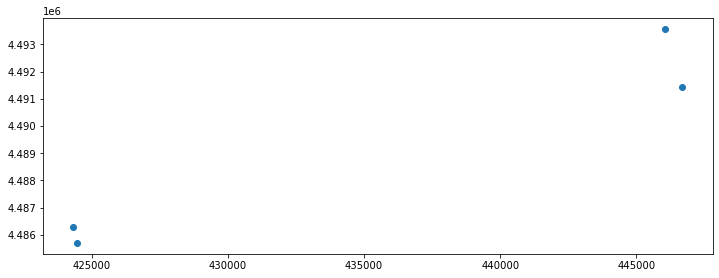

In [25]:
f, ax = plt.subplots(figsize = (12,8))
points_within.plot(ax = ax)
ctx.add_basemap(ax = ax, crs = df_range.crs, source = ctx.providers.Stamen.Terrain)